## Model

In [1]:
import numpy as np
import sys

class ANN:
    def __init__(self, input_shape, layers, loss):
        self.num_layers = len(layers)
        self.layers = [np.prod(input_shape)] + [i[0] for i in layers]
        self.activations = [i[1] for i in layers]
        self.loss = loss
        self.weights = [np.random.randn(i, j) * np.sqrt(1. / j) for i, j in zip(self.layers[1:], self.layers[:-1])]
        self.biases = [np.zeros((i, 1)) for i in self.layers[1:]]
    
    #-------------------------------------- activation functions -----------------------------------------
    def sigmoid(self, Z):
        return 1. / (1. + np.exp(-Z))
    
    def relu(self, Z):
        return np.maximum(0, Z)
    
    def tanh(self, Z):
        return np.tanh(Z)
    
    def softmax(self, Z):
        return np.exp(Z) / np.sum(np.exp(Z), axis=0)
    
    def linear(self, Z):
        return Z
    
    #--------------------------------- derivatives of activation functions ---------------------------------
    def sigmoid_derivative(self, Z):
        return self.sigmoid(Z) * (1 - self.sigmoid(Z))
    
    def relu_derivative(self, Z):
        return np.where(Z <= 0, 0, 1)
    
    def tanh_derivative(self, Z):
        return 1 - np.tanh(Z)**2
    
    def softmax_derivative(self, Z):
        return self.softmax(Z) * (1 - self.softmax(Z))
    
    def linear_derivative(self, Z):
        return np.ones_like(Z)
    
    #--------------------------------------------- loss functions -----------------------------------------
    def mean_squared_error(self, y, y_hat):
        return np.mean((y_hat - y) ** 2)
    
    def binary_cross_entropy(self, y, y_hat):
        return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    
    def categorical_cross_entropy(self, y, y_hat):
        return -np.mean(np.sum(y * np.log(y_hat), axis=0))
    
    def compute_accuracy(self, y, y_pred):
        correct_predictions = np.equal(np.argmax(y, axis=0), np.argmax(y_pred, axis=0))
        return np.mean(correct_predictions.astype(float))
    
    #----------------------------------------------- Feedforward ------------------------------------------
    def feed_forward(self, layer_activation):
        cache = []
        for i in range(self.num_layers):
            layer_multiplication = np.matmul(self.weights[i], layer_activation) + self.biases[i]
            layer_activation = eval('self.' + self.activations[i] + '(layer_multiplication)')
            
            cache.append([layer_multiplication, layer_activation])
        return cache
    
    #----------------------------------------------- Backpropagation ------------------------------------------
    def back_propagate(self, X, y, cache, m_batch):
        grad = []
        for i in range(self.num_layers-1,-1,-1):
            if i==self.num_layers-1:
                delta = cache[-1][1] - y
            else:
                delta = np.matmul(self.weights[i+1].T, delta) * eval('self.' + self.activations[i] + '_derivative(cache[i][0])')
            
            if i==0: cache[i-1][1] = X
            weight_grad = (1. / m_batch) * np.matmul(delta, cache[i-1][1].T)
            bias_grad = (1. / m_batch) * np.sum(delta, axis=1, keepdims=True)
            
            grad.append([weight_grad, bias_grad])
        return grad
        
    #---------------------------------------------------- Train -----------------------------------------------
    def fit(self, X_train, y_train, validation_data=None, epochs=1, batch_size=64,
                                learning_rate=1e-3, history=False, shuffle=True):
        
        # data transpose
        X_train = X_train.T
        y_train = y_train.T
        if validation_data:
            X_test = validation_data[0].T
            y_test = validation_data[1].T
        
        # for history
        train_losses = []
        test_losses = []
        train_accuracies = []
        test_accuracies = []
        
        for i in range(epochs):
            if shuffle:
                permutation = np.random.permutation(X_train.shape[1])
                X_train = X_train[:, permutation]
                y_train = y_train[:, permutation]
            
            print(f"Epoch {i + 1}/{epochs}")
            batches = X_train.shape[1] // batch_size
            for j in range(batches):

                begin = j * batch_size
                end = min(begin + batch_size, X_train.shape[1] - 1)
                X = X_train[:, begin:end]
                y = y_train[:, begin:end]
                m_batch = end - begin

                # forward and backward
                cache = self.feed_forward(X)
                grad = self.back_propagate(X, y, cache, m_batch)

                # gradient descent
                for k in range(self.num_layers):
                    self.weights[k] -= learning_rate * grad[-k-1][0]
                    self.biases[k] -= learning_rate * grad[-k-1][1]

                # evaluation on training set
                cache = self.feed_forward(X)
                batch_loss = eval('self.'+self.loss+'(y, cache[-1][1])')
                
                print(f"{str(j+1).ljust(len(str(batches)),' ')}/{batches} [{('='*int((j+1)*20/batches)).ljust(20, '.')}] - loss: {round(batch_loss,4)}" if j==batches-1 else 
                      f"{str(j+1).ljust(len(str(batches)),' ')}/{batches} [{('='*int((j+1)*20/batches)+'>').ljust(20, '.')}] - loss: {round(batch_loss,4)}", end='\r')

            # evaluation on training set
            cache = self.feed_forward(X_train)
            train_loss = eval('self.'+self.loss+'(y_train, cache[-1][1])')
            train_losses.append(train_loss)
            train_acc = self.compute_accuracy(y_train, cache[-1][1])
            train_accuracies.append(train_acc)
            
            # fevaluation on test set
            if validation_data:
                cache = self.feed_forward(X_test)
                test_loss = eval('self.'+self.loss+'(y_test, cache[-1][1])')
                test_losses.append(test_loss)
                test_acc = self.compute_accuracy(y_test, cache[-1][1])
                test_accuracies.append(test_acc)
                print(f"{str(j+1).ljust(len(str(batches)),' ')}/{batches} [{('='*int((j+1)*20/batches)).ljust(20, '.')}] - loss: {round(train_loss,4)} - accuracy: {round(train_acc,4)} - val_loss: {round(test_loss,4)} - val_accuracy: {round(test_acc,4)}")
                sys.stdout.flush()
            else:
                print(f"{str(j+1).ljust(len(str(batches)),' ')}/{batches} [{('='*int((j+1)*20/batches)).ljust(20, '.')}] - loss: {round(train_loss,4)} - accuracy: {round(train_acc,4)}")
                
        if history:
            return {"epoch":range(1,epochs+1), "loss":train_losses, "val_loss":test_losses, "accuracy":train_accuracies, "val_accuracy":test_accuracies}
    
    #---------------------------------------------------- Predict -----------------------------------------------
    def predict(self, test):
        return self.feed_forward(test.T)[-1][1].T

## Multi-label classification

### Data preparation

In [2]:
from tensorflow import keras

mnist = keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784) / 255.0
y_train = y_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 784) / 255.0
y_test  = y_test.reshape(-1, 1)

y_train = np.eye(10)[y_train.astype('int32')]
y_train = y_train.reshape(60000, 10)

y_test = np.eye(10)[y_test.astype('int32')]
y_test = y_test.reshape(10000, 10)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 784) (60000, 10) (10000, 784) (10000, 10)


### Train

In [3]:
model = ANN(input_shape = X_train.shape[1:], 
    layers = [
        [64 , 'sigmoid'],
        [10 , 'softmax']
    ],
    loss='categorical_cross_entropy')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64, learning_rate=0.5, history=True)

Epoch 1/10
937/937 [====================] - loss: 0.2557 - accuracy: 0.9266 - val_loss: 0.252 - val_accuracy: 0.9304
Epoch 2/10
937/937 [====================] - loss: 0.1939 - accuracy: 0.9432 - val_loss: 0.1969 - val_accuracy: 0.9429
Epoch 3/10
937/937 [====================] - loss: 0.1497 - accuracy: 0.9572 - val_loss: 0.1547 - val_accuracy: 0.9543
Epoch 4/10
937/937 [====================] - loss: 0.1354 - accuracy: 0.9606 - val_loss: 0.1434 - val_accuracy: 0.9573
Epoch 5/10
937/937 [====================] - loss: 0.1108 - accuracy: 0.968 - val_loss: 0.1237 - val_accuracy: 0.9626
Epoch 6/10
937/937 [====================] - loss: 0.1005 - accuracy: 0.9712 - val_loss: 0.1154 - val_accuracy: 0.9648
Epoch 7/10
937/937 [====================] - loss: 0.0898 - accuracy: 0.9743 - val_loss: 0.1078 - val_accuracy: 0.9672
Epoch 8/10
937/937 [====================] - loss: 0.0789 - accuracy: 0.9777 - val_loss: 0.0988 - val_accuracy: 0.9689
Epoch 9/10
937/937 [====================] - loss: 0.0727 -

### Evaluation

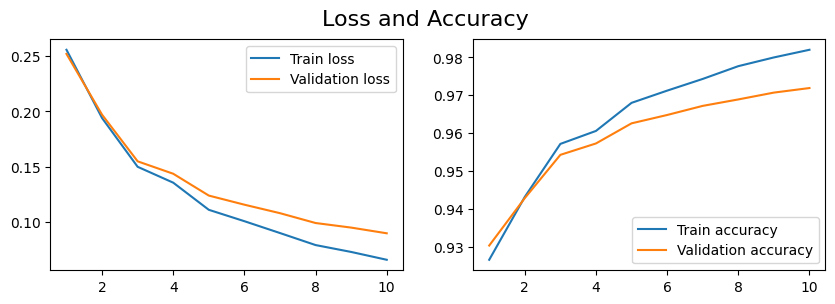

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history["epoch"], history["loss"], label="Train loss")
ax[0].plot(history["epoch"], history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history["epoch"], history["accuracy"], label="Train accuracy")
ax[1].plot(history["epoch"], history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()